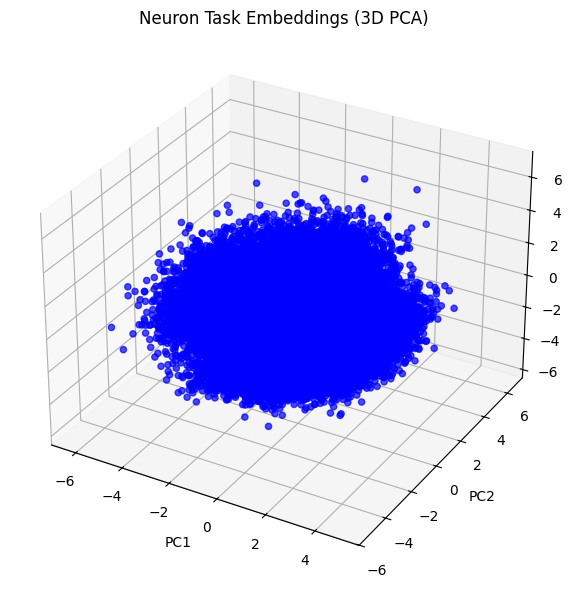

In [ ]:
import torch
import torch.nn as nn

class AttentionNullModel(nn.Module):
    def __init__(self, vit_dim, neuron_embed_dim, num_neurons, attention_dim, mlp_dim=128):
        super().__init__()
        self.neuron_embedding = nn.Embedding(num_neurons, neuron_embed_dim)

        self.input_proj = nn.Linear(vit_dim + neuron_embed_dim, attention_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=attention_dim,
            num_heads=1,
            batch_first=True
        )

        # MLP block like in Transformer
        self.mlp = nn.Sequential(
            nn.LayerNorm(attention_dim),
            nn.Linear(attention_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, attention_dim)
        )

        self.out = nn.Linear(attention_dim, 1)

    def forward(self, image_embedding, neuron_idx):
        # image_embedding: (B, D)
        # neuron_idx: (B,)
        neuron_emb = self.neuron_embedding(neuron_idx)  # (B, E)
        x = torch.cat([image_embedding, neuron_emb], dim=-1)  # (B, D+E)
        x = self.input_proj(x).unsqueeze(1)  # (B, 1, A)

        # Self-attention
        attn_out, _ = self.attn(x, x, x)  # (B, 1, A)

        # Transformer-style residual + MLP
        residual = attn_out
        mlp_out = self.mlp(attn_out)
        final = residual + mlp_out  # (B, 1, A)

        logits = self.out(final.squeeze(1))  # (B, A) -> (B,)
        return logits

import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Load the model
model_path = "/home/maria/LuckyMouse2/saved_models/fold_0/model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionNullModel(
    vit_dim=1000,
    neuron_embed_dim=64,
    num_neurons=39209,
    attention_dim=128
).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Extract embeddings
with torch.no_grad():
    neuron_embeddings = model.neuron_embedding.weight.cpu().numpy()  # shape (num_neurons, neuron_embed_dim)

# PCA to 3D
pca = PCA(n_components=3)
neuron_embeddings_3d = pca.fit_transform(neuron_embeddings)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    
    neuron_embeddings_3d[:, 0],
    neuron_embeddings_3d[:, 1],
    neuron_embeddings_3d[:, 2],
    c='blue',
    alpha=0.7
)

ax.set_title("Neuron Task Embeddings (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()


In [5]:
!pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.24.0-py3-none-any.whl (88 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.1/386.1 kB 9.1 MB/s eta 0:00:00ta 0:00:01


In [8]:
import torch
from sklearn.decomposition import PCA
import plotly.express as px

# Load the model
model_path = "/home/maria/LuckyMouse2/saved_models/fold_0/model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the correct architecture from checkpoint
model = AttentionNullModel(
    vit_dim=1000,
    neuron_embed_dim=64,
    num_neurons=39209,
    attention_dim=128
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Extract neuron embeddings
with torch.no_grad():
    neuron_embeddings = model.neuron_embedding.weight.cpu().numpy()  # (39209, 64)

# PCA to 3D
pca = PCA(n_components=3)
neuron_embeddings_3d = pca.fit_transform(neuron_embeddings)

# Interactive 3D plot using Plotly
fig = px.scatter_3d(
    x=neuron_embeddings_3d[:, 0],
    y=neuron_embeddings_3d[:, 1],
    z=neuron_embeddings_3d[:, 2],
    opacity=0.7,
    title="Neuron Task Embeddings (3D PCA)",
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
)

fig.update_traces(marker=dict(size=2))
import plotly.io as pio
pio.renderers.default = "browser"
fig.show()


In [9]:
!pip install umap-learn

  Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.44.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.4 MB/s eta 0:00:00
Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.9 MB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached llvmlite-0.44.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.4 MB)


In [10]:
from umap import UMAP

umap = UMAP(n_components=3)
embeddings_umap = umap.fit_transform(neuron_embeddings)

/home/maria/global_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [11]:
# Interactive 3D plot using Plotly
fig = px.scatter_3d(
    x=embeddings_umap[:, 0],
    y=embeddings_umap[:, 1],
    z=embeddings_umap[:, 2],
    opacity=0.7,
    title="Neuron Task Embeddings (3D UMAP)",
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
)

fig.update_traces(marker=dict(size=2))
import plotly.io as pio
pio.renderers.default = "browser"
fig.show()

In [12]:
import numpy as np
import plotly.express as px
import plotly.io as pio

# Assign a unique color for each neuron based on its row index
neuron_ids = np.arange(len(embeddings_umap))  # or len(neuron_embeddings) if not UMAP

# Interactive 3D plot using Plotly
fig = px.scatter_3d(
    x=embeddings_umap[:, 0],
    y=embeddings_umap[:, 1],
    z=embeddings_umap[:, 2],
    color=neuron_ids,  # 👈 color by neuron order
    opacity=0.7,
    title="Neuron Task Embeddings (3D UMAP)",
    labels={'x': 'UMAP-1', 'y': 'UMAP-2', 'z': 'UMAP-3'},
    color_continuous_scale='Viridis'  # or any Plotly colormap
)

fig.update_traces(marker=dict(size=2))
pio.renderers.default = "browser"
fig.show()
